In [2]:
import os
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchtext.legacy import data
import time
import random

#Note:
#'codes taken from' means codes are copied from a source
# 'codes based on' or 'codes modified from' mean techniques from the source are used with adjustments according to the specific task 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bun233\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#ignore warnings for better presentation
warnings.filterwarnings('ignore')

In [4]:
#load data
raw_140_train=pd.read_csv('s140_train.csv',header=None)
raw_140_test=pd.read_csv('s140_test.csv',header=None)
raw_tomato_train=pd.read_csv('rtmr_train.tsv',sep='\t')
raw_tomato_test=pd.read_csv('rtmr_test.tsv',sep='\t')
    

In [5]:
#tokenise and store in lower case
tweets_tokenised_train=[word_tokenize(i.lower()) for i in raw_140_train[5].tolist()]
tweets_label_train=raw_140_train[0].tolist()
tweets_tokenised_test=[word_tokenize(i.lower()) for i in raw_140_test[5].tolist()]
tweets_label_test=raw_140_test[0].tolist()

tomato_tokenised_train=[word_tokenize(i.lower()) for i in raw_tomato_train['Phrase'].tolist()]
tomato_label_train=raw_tomato_train['Sentiment'].tolist()
tomato_tokenised_test=[word_tokenize(i.lower()) for i in raw_tomato_test['Phrase'].tolist()]
tomato_label_test=raw_tomato_test['Sentiment'].tolist()

In [6]:
#data distribution
print('tweets_label_train: ',Counter(tweets_label_train))
print('tweets_label_test: ',Counter(tweets_label_test))
print('tomato_label_train: ',Counter(tomato_label_train))
print('tomato_label_test: ',Counter(tomato_label_test))

tweets_label_train:  Counter({0: 800000, 4: 800000})
tweets_label_test:  Counter({4: 182, 0: 177, 2: 139})
tomato_label_train:  Counter({2: 75555, 3: 31289, 1: 25872, 4: 8774, 0: 6766})
tomato_label_test:  Counter({2: 4027, 3: 1638, 1: 1400, 4: 432, 0: 306})


In [7]:
#preprocessing
tweets_cleaned_train=tweets_tokenised_train
for tweet in range(len(tweets_tokenised_train)):
    tweet_cleaned=[]
    for word in tweets_tokenised_train[tweet]: #normalise abbreviations and terminologies
        word=word.replace('-','')
        word=word.replace('.','')
        if word not in list(punctuation): #remove punctuation
            if word not in stopwords.words('english'):
                if len(word)>1: #store words with 4 characters or more, corresponding to the size of convolution kernels
                    tweet_cleaned.append(word)
    tweets_cleaned_train[tweet]=tweet_cleaned
train_140=[' '.join(tweets_cleaned_train[i]) for i in range(len(tweets_cleaned_train))]

tweets_cleaned_test=tweets_tokenised_test
for tweet in range(len(tweets_tokenised_test)):
    tweet_cleaned_test=[]
    for word in tweets_tokenised_test[tweet]:
        word=word.replace('-','')
        word=word.replace('.','')
        if word not in list(punctuation):
            if word not in stopwords.words('english'):
                if len(word)>1:
                    tweet_cleaned_test.append(word)
    tweets_cleaned_test[tweet]=tweet_cleaned_test
test_140=[' '.join(tweets_cleaned_test[i]) for i in range(len(tweets_cleaned_test))]

tomato_cleaned_train=tomato_tokenised_train
for review in range(len(tomato_tokenised_train)):
    review_cleaned=[]
    for word in tomato_tokenised_train[review]:
        word=word.replace('-','')
        word=word.replace('.','')
        if word not in list(punctuation):
            if word not in stopwords.words('english'):
                if len(word)>1:
                    review_cleaned.append(word)
    tomato_cleaned_train[review]=review_cleaned
train_tomato=[' '.join(tomato_cleaned_train[i]) for i in range(len(tomato_cleaned_train))]

tomato_cleaned_test=tomato_tokenised_test
for review in range(len(tomato_tokenised_test)):
    review_cleaned=[]
    for word in tomato_tokenised_test[review]:
        word=word.replace('-','')
        word=word.replace('.','')
        if word not in list(punctuation):
            if word not in stopwords.words('english'):
                if len(word)>1:
                    review_cleaned.append(word)
    tomato_cleaned_test[review]=review_cleaned
test_tomato=[' '.join(tomato_cleaned_test[i]) for i in range(len(tomato_cleaned_test))]

train_combined=train_140+train_tomato
train_combined_label=tweets_label_train+tomato_label_train

In [8]:
#matches the previous one
print('tweets_label_train: ',Counter(tweets_label_train))
print('tweets_label_test: ',Counter(tweets_label_test))
print('tomato_label_train: ',Counter(tomato_label_train))
print('tomato_label_test: ',Counter(tomato_label_test))

tweets_label_train:  Counter({0: 800000, 4: 800000})
tweets_label_test:  Counter({4: 182, 0: 177, 2: 139})
tomato_label_train:  Counter({2: 75555, 3: 31289, 1: 25872, 4: 8774, 0: 6766})
tomato_label_test:  Counter({2: 4027, 3: 1638, 1: 1400, 4: 432, 0: 306})


In [9]:
#this block prepares processed documents for neural networks
df_train_rmtr_processed=pd.concat([pd.DataFrame({'text':tomato_cleaned_train}),pd.DataFrame({'label':tomato_label_train})],axis=1)
df_test_rmtr_processed=pd.concat([pd.DataFrame({'text':tomato_cleaned_test}),pd.DataFrame({'label':tomato_label_test})],axis=1)
df_test_s140_processed=pd.concat([pd.DataFrame({'text':tweets_cleaned_test}),pd.DataFrame({'label':tweets_label_test})],axis=1)

df_train_rmtr_processed.to_csv('rmtr_train_processed.csv',index=False)
df_test_rmtr_processed.to_csv('rmtr_test_processed.csv',index=False)
df_test_s140_processed.to_csv('s140_test_processed.csv',index=False)

In [10]:
#Codes in this block are based on workshop 7.3.2 Text classification using Naive Bayes

#train on RTMR and test on RTMR and s140
model_NB_rtmr = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_NB_rtmr.fit(train_tomato,tomato_label_train)
NB_rmtr_predicted_by_rmtr=model_NB_rtmr.predict(test_tomato)
NB_s140_predicted_by_rmtr=model_NB_rtmr.predict(test_140)

#train on s140 and test on RTMR and s140
model_NB_s140 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_NB_s140.fit(train_140,tweets_label_train)
NB_rtmr_predicted_by_s140=model_NB_s140.predict(test_tomato)
NB_s140_predicted_by_s140=model_NB_s140.predict(test_140)

#train on combined and test on RTMR and s140
model_NB_combined = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_NB_combined.fit(train_combined,train_combined_label)
NB_rtmr_predicted_by_combined=model_NB_combined.predict(test_tomato)
NB_s140_predicted_by_combined=model_NB_combined.predict(test_140)

In [11]:
#this block is taken from workshop 7.4.1
pkl_filename = "NB_rtmr.pkl"
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model_NB_rtmr, file)

pkl_filename = "NB_s140.pkl"
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model_NB_s140, file)

pkl_filename = "NB_combined.pkl"
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model_NB_combined, file)

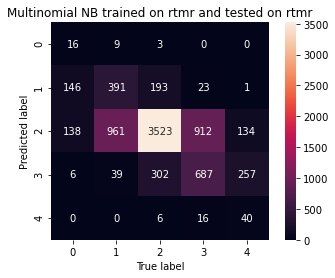

Accuracy (rtmr on rtmr):  0.5968217352300397
F1-score (rtmr on rtmr):  0.36333313137273626
Precision (rtmr on rtmr):  0.5777725515167214
Recall (rtmr on rtmr):  0.3436849211215328




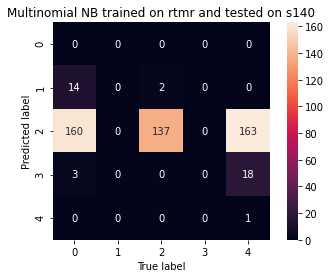

Accuracy (s140 on rtmr):  0.27710843373493976
F1-score (s140 on rtmr):  0.09367160203253146
Precision (s140 on rtmr):  0.25956521739130434
Recall (s140 on rtmr):  0.19822120325717446




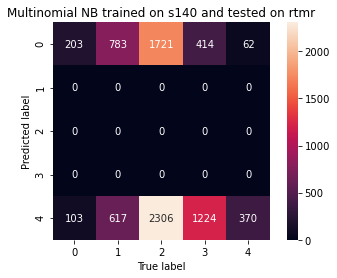

Accuracy (rtmr on s140):  0.07343329488658208
F1-score (rtmr on s140):  0.052568472750122705
Precision (rtmr on s140):  0.028772578348450168
Recall (rtmr on s140):  0.3039760348583878




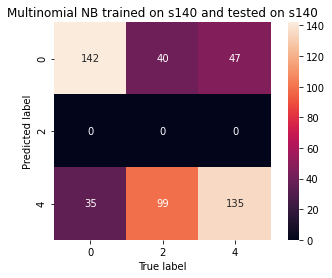

Accuracy (s140 on s140):  0.5562248995983936
F1-score (s140 on s140):  0.43272567074080953
Precision (s140 on s140):  0.3739820241013403
Recall (s140 on s140):  0.5146727095879639




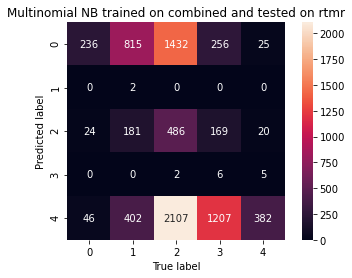

Accuracy (rtmr on combined):  0.14250929129821863
F1-score (rtmr on combined):  0.1057819457682448
Precision (rtmr on combined):  0.43827523163268467
Recall (rtmr on combined):  0.3562556076287069




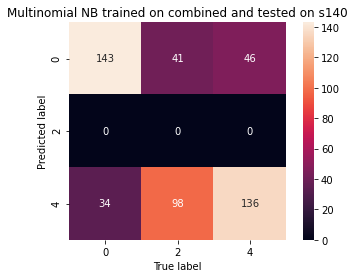

Accuracy (s140 on combined):  0.5602409638554217
F1-score (s140 on combined):  0.43571571571571566
Precision (s140 on combined):  0.37640060566731554
Recall (s140 on combined):  0.5183874505908405


In [12]:
#test on naive bayes models
#rtmr on rtmr
mat = confusion_matrix(tomato_label_test,NB_rmtr_predicted_by_rmtr)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d") #this line is from workshop 7.3.3
plt.title('Multinomial NB trained on rtmr and tested on rtmr')
plt.xlabel("True label")

plt.ylabel("Predicted label")
plt.show()
print('Accuracy (rtmr on rtmr): ',accuracy_score(tomato_label_test,NB_rmtr_predicted_by_rmtr))
print('F1-score (rtmr on rtmr): ',f1_score(tomato_label_test,NB_rmtr_predicted_by_rmtr,average='macro'))
print('Precision (rtmr on rtmr): ',precision_score(tomato_label_test,NB_rmtr_predicted_by_rmtr,average='macro'))
print('Recall (rtmr on rtmr): ',recall_score(tomato_label_test,NB_rmtr_predicted_by_rmtr,average='macro'))
print('\n')

#s140 on rtmr
mat = confusion_matrix(tweets_label_test,NB_s140_predicted_by_rmtr)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d") 
plt.title('Multinomial NB trained on rtmr and tested on s140')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print('Accuracy (s140 on rtmr): ',accuracy_score(tweets_label_test,NB_s140_predicted_by_rmtr))
print('F1-score (s140 on rtmr): ',f1_score(tweets_label_test,NB_s140_predicted_by_rmtr,average='macro'))
print('Precision (s140 on rtmr): ',precision_score(tweets_label_test,NB_s140_predicted_by_rmtr,average='macro'))
print('Recall (s140 on rtmr): ',recall_score(tweets_label_test,NB_s140_predicted_by_rmtr,average='macro'))
print('\n')

#rmtr on s140
mat = confusion_matrix(tomato_label_test,NB_rtmr_predicted_by_s140)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d") #this line is from workshop 7.3.3
plt.title('Multinomial NB trained on s140 and tested on rtmr')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print('Accuracy (rtmr on s140): ',accuracy_score(tomato_label_test,NB_rtmr_predicted_by_s140))
print('F1-score (rtmr on s140): ',f1_score(tomato_label_test,NB_rtmr_predicted_by_s140,average='macro'))
print('Precision (rtmr on s140): ',precision_score(tomato_label_test,NB_rtmr_predicted_by_s140,average='macro'))
print('Recall (rtmr on s140): ',recall_score(tomato_label_test,NB_rtmr_predicted_by_s140,average='macro'))
print('\n')

#s140 on s140
mat = confusion_matrix(tweets_label_test,NB_s140_predicted_by_s140)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",xticklabels=[0,2,4],yticklabels=[0,2,4]) 
plt.title('Multinomial NB trained on s140 and tested on s140')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print('Accuracy (s140 on s140): ',accuracy_score(tweets_label_test,NB_s140_predicted_by_s140))
print('F1-score (s140 on s140): ',f1_score(tweets_label_test,NB_s140_predicted_by_s140,average='macro'))
print('Precision (s140 on s140): ',precision_score(tweets_label_test,NB_s140_predicted_by_s140,average='macro'))
print('Recall (s140 on s140): ',recall_score(tweets_label_test,NB_s140_predicted_by_s140,average='macro'))
print('\n')

#rmtr on combined
mat = confusion_matrix(tomato_label_test,NB_rtmr_predicted_by_combined)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d") #this line is from workshop 7.3.3
plt.title('Multinomial NB trained on combined and tested on rtmr')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print('Accuracy (rtmr on combined): ',accuracy_score(tomato_label_test,NB_rtmr_predicted_by_combined))
print('F1-score (rtmr on combined): ',f1_score(tomato_label_test,NB_rtmr_predicted_by_combined,average='macro'))
print('Precision (rtmr on combined): ',precision_score(tomato_label_test,NB_rtmr_predicted_by_combined,average='macro'))
print('Recall (rtmr on combined): ',recall_score(tomato_label_test,NB_rtmr_predicted_by_combined,average='macro'))
print('\n')

#s140 on combined
mat = confusion_matrix(tweets_label_test,NB_s140_predicted_by_combined)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",xticklabels=[0,2,4],yticklabels=[0,2,4]) 
plt.title('Multinomial NB trained on combined and tested on s140')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print('Accuracy (s140 on combined): ',accuracy_score(tweets_label_test,NB_s140_predicted_by_combined))
print('F1-score (s140 on combined): ',f1_score(tweets_label_test,NB_s140_predicted_by_combined,average='macro'))
print('Precision (s140 on combined): ',precision_score(tweets_label_test,NB_s140_predicted_by_combined,average='macro'))
print('Recall (s140 on combined): ',recall_score(tweets_label_test,NB_s140_predicted_by_combined,average='macro'))

In [13]:
#Text Preprocessing for NNs
RANDOM_SEED=33
torch.manual_seed=RANDOM_SEED

#the next 2 lines are taken from workshop 8.1.3 Create Pytorch dataset
TEXT=data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True)
LABEL=data.LabelField(dtype = torch.float,batch_first=True)


#the next lines are based on workshop 8.1.3 Create Pytorch dataset
fields = [('text',TEXT),('label', LABEL)]

train=data.TabularDataset(path = 'rmtr_train_processed.csv',format = 'csv',fields = fields,skip_header = True)
test_rmtr=data.TabularDataset(path = 'rmtr_test_processed.csv',format = 'csv',fields = fields,skip_header = True)
test_s140=data.TabularDataset(path = 's140_test_processed.csv',format = 'csv',fields = fields,skip_header = True)

train,validation=train.split(split_ratio=0.8,random_state=random.seed(RANDOM_SEED))

TEXT.build_vocab(train,vectors='glove.6B.100d',min_freq=1) #use pre-trained embeddings from GloVe
LABEL.build_vocab(train)
torch.save(TEXT.vocab,'vocab.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [14]:
print("Size of TEXT vocabulary:",len(TEXT.vocab)) # Number of unique tokens in vocabulary
print("Size of LABEL vocabulary:",len(LABEL.vocab),"\n") # Number of unique labels

print("Most common tokens:",TEXT.vocab.freqs.most_common(10),"\n")  # Print the 10 most common tokens in the training set

# Print the index number for the unknown token (<unk>) and the token used for padding (<pad>)
print("Index of unknown word <unk>:",TEXT.vocab.stoi['<unk>'])
print("Index of padding word <pad>:",TEXT.vocab.stoi['<pad>'])

Size of TEXT vocabulary: 16252
Size of LABEL vocabulary: 5 

Most common tokens: [("'", 468085), (',', 365621), ('[', 118605), (']', 118605), ('``', 20752), ("''", 18131), ("'s", 12869), ("'film", 5060), ("'movie", 4433), ("n't", 3035)] 

Index of unknown word <unk>: 0
Index of padding word <pad>: 1


In [15]:
#this block is modified from workshop 8.1.6 Create iterators for the training and test data
BATCH_SIZE=1000

#create training and validation iterators
train_rmtr_iterator,validation_rmtr_iterator=data.BucketIterator.splits(
    (train,validation),
    batch_size=BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

#create testing iterators
test_rmtr_iterator=data.BucketIterator(test_rmtr,
    batch_size=7803, #there are 7803 reviews in the rmtr testing set
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

test_s140_iterator=data.BucketIterator(test_s140,
    batch_size=498, #there are 498 tweets in the s140 testing set
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [16]:
#this block and the next block are taken from https://towardsdatascience.com/cnn-sentiment-analysis-9b1771e7cdd6 with slight modifications
class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        self.act=nn.Softmax()
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).unsqueeze(1)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        densed=self.linear(cat)
        output=self.act(densed)
        return output

In [17]:
INPUT_DIM = len(TEXT.vocab)

EMBEDDING_DIM = 100

N_FILTERS = 100

FILTER_SIZES = [1, 2]

OUTPUT_DIM = 5

DROPOUT = 0.5

# Zero the initial weights of the UNKnown and padding tokens.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# The string token used as padding. Default: “<pad>”.
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Initialize model and load pre-trained embeddings
model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, 
            N_FILTERS, FILTER_SIZES, 
            OUTPUT_DIM, DROPOUT, PAD_IDX)

model.embedding.weight.data.copy_(TEXT.vocab.vectors)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) #set unk and pad token to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model.parameters(),lr=0.00001) #low learning rate to prevent gradient vanishing
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(device)
model = model.to(device)

In [18]:
#training & evaluation function for cnn
#this block is largely taken from workshop 8.2.4 Define training function and 8.2.5 Define evaluation function

def accuracy(preds, y): #the accuracy function is from https://blog.csdn.net/A496608119/article/details/120519679
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_fun_cnn(model,iterator,optimizer,criterion):
    epoch_loss=0
    epoch_acc=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        #print(batch.label)
        text, text_lengths = batch.text #extract text from (text,text_lengths) tuple
        predictions=model(text)
        #print(predictions)
        loss=criterion(predictions,batch.label.long())
        acc=accuracy(predictions,batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluation_fun_cnn(model,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text #separate text from (text,text_lengths) tuple
            predictions=model(text)
            loss=criterion(predictions,batch.label.long())
            acc=accuracy(predictions,batch.label)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
#define testing functions for the model selected by validation

def report(preds,y): #produce required metrics
    pred = preds.argmax(1, keepdim = True)
    acc=accuracy_score(y,pred)
    f1=f1_score(y,pred,average='macro')
    prec=precision_score(y,pred,average='macro')
    recl=recall_score(y,pred,average='macro')
    return print('Accuracy: ',acc,'\n','F1-score: ',f1,'\n','Precision: ',prec,'\n','Recall: ',recl,'\n')

def heatmat_NN(preds,y): #create heatmaps
    pred = preds.argmax(1, keepdim = True)
    mat = confusion_matrix(y,pred)
    sns.heatmap(mat.T, square = True, annot=True, fmt = "d") 
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    return plt.show()

def test_fun(model,iterator): #testing function for cnn
    model.eval()
    for batch in iterator:
        text, text_lengths = batch.text #extract both but only text is usable in cnn
        predictions=model(text)
        performance=report(predictions,batch.label)
        mat=heatmat_NN(predictions,batch.label)
    return print(performance),mat

In [20]:
#training and validation
#this block is largely taken from workshop 8.3 and exercise 8.1
N_EPOCHS=20
best_valid_loss=float('inf')
best_valid_acc=float('inf')
best_epoch=0
epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []

for epoch in range(N_EPOCHS):
    print("Epoch %3d:" % epoch,end='')
    start=time.time()
    train_loss, train_acc = train_fun_cnn(model, train_rmtr_iterator, optimizer, criterion) #compute and store loss and accuracy
    epoch_loss_train.append(train_loss)
    epoch_accuracy_train.append(train_acc)
    valid_loss,valid_acc=evaluation_fun_cnn(model,validation_rmtr_iterator,criterion)
    epoch_loss_valid.append(valid_loss)
    epoch_accuracy_valid.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch 
        torch.save(model, 'CNN.pth') 
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))

print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" % (best_epoch,best_valid_loss,best_valid_acc))
        
        

Epoch   0: Train loss: 1.566 | Train acuracy: 0.4274 | Validation loss: 1.549 | Validation acuracy: 0.5036 - 7.69 s
Epoch   1: Train loss: 1.533 | Train acuracy: 0.4976 | Validation loss: 1.517 | Validation acuracy: 0.5036 - 7.76 s
Epoch   2: Train loss: 1.503 | Train acuracy: 0.5085 | Validation loss: 1.490 | Validation acuracy: 0.5036 - 7.65 s
Epoch   3: Train loss: 1.479 | Train acuracy: 0.5091 | Validation loss: 1.468 | Validation acuracy: 0.5036 - 7.76 s
Epoch   4: Train loss: 1.460 | Train acuracy: 0.5092 | Validation loss: 1.453 | Validation acuracy: 0.5036 - 7.75 s
Epoch   5: Train loss: 1.447 | Train acuracy: 0.5093 | Validation loss: 1.442 | Validation acuracy: 0.5036 - 7.71 s
Epoch   6: Train loss: 1.437 | Train acuracy: 0.5092 | Validation loss: 1.434 | Validation acuracy: 0.5036 - 7.79 s
Epoch   7: Train loss: 1.429 | Train acuracy: 0.5092 | Validation loss: 1.428 | Validation acuracy: 0.5036 - 8.00 s
Epoch   8: Train loss: 1.423 | Train acuracy: 0.5092 | Validation loss: 

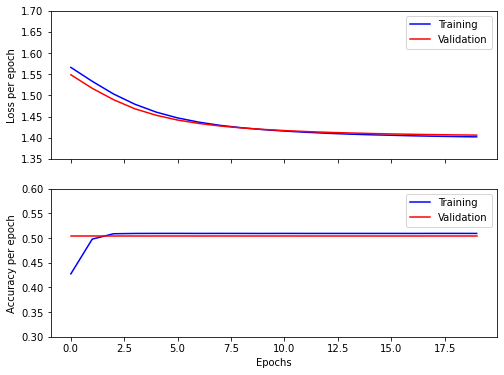

In [21]:
#this block is taken from exercise 8.1
eps = np.arange(N_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.set_ylim([1.35, 1.7])
ax1.plot(epoch_loss_train,'b')
ax1.plot(epoch_loss_valid,'r')
ax1.set_ylabel("Loss per epoch")
ax1.legend(["Training","Validation"])

ax2.set_ylim([0.3, 0.6])
ax2.plot(epoch_accuracy_train,'b')
ax2.plot(epoch_accuracy_valid,'r')
ax2.set_ylabel("Accuracy per epoch")
ax2.set_xlabel("Epochs")
ax2.legend(["Training","Validation"])
plt.show()

In [22]:
'''
Although both training and validation accuracy remain flat after epoch 2, there is a steady downward trend in terms of both training and validation accuracy,
indicating that the model is not fully trained. Larger epoch number should be implemented for further work.

While increasing learning rate is a potential option, this has been tried but validation loss remained constant, which is why this method is not presented.
'''

'\nAlthough both training and validation accuracy remain flat after epoch 2, there is a steady downward trend in terms of both training and validation accuracy,\nindicating that the model is not fully trained. Larger epoch number should be implemented for further work.\n\nWhile increasing learning rate is a potential option, this has been tried but validation loss remained constant, which is why this method is not presented.\n'

Accuracy:  0.516083557606049 
 F1-score:  0.13616229923922232 
 Precision:  0.10321671152120979 
 Recall:  0.2 



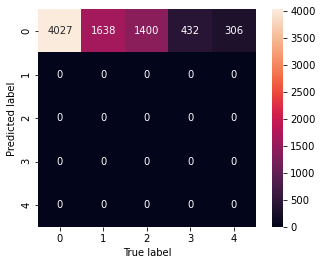

None
Accuracy:  0.2791164658634538 
 F1-score:  0.1454735740450026 
 Precision:  0.0930388219544846 
 Recall:  0.3333333333333333 



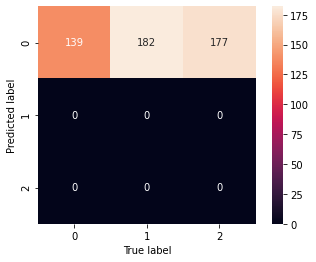

None


(None, None)

In [23]:
#this block only works when the last epoch is the best epoch (in my case it is)
test_fun(model,test_rmtr_iterator) #test the selected model on rmtr testing set
test_fun(model,test_s140_iterator) #test the selected model on s140 testing set

In [24]:
#LSTM
#this block is taken from block 8.2 Create LSTM architecture 
class LSTM_rmtr(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,num_layers=n_layers,bidirectional=bidirectional,dropout=dropout,batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Softmax()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc1(hidden)
        outputs=self.act(dense_outputs)
        return outputs

vocabulary_size = len(TEXT.vocab)
embedding_dimensions = 100
LSTM_no_of_hidden_nodes = 16
LSTM_no_of_recurrent_layers = 2
LSTM_bidirection = True
LSTM_dropout = 0.2 
output_size = 5

model_lstm = LSTM_rmtr(vocabulary_size, embedding_dimensions, LSTM_no_of_hidden_nodes, 
                    output_size, LSTM_no_of_recurrent_layers, 
                    bidirectional = LSTM_bidirection,dropout = LSTM_dropout)


print("Model architecture:\n",model_lstm) 

def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("\nThe model has",count_parameters(model_lstm),"trainable parameters")

optimizer = optim.Adam(model_lstm.parameters(),lr=0.0001) #small learning rate to prevent gradient vanishing
criterion = nn.CrossEntropyLoss()
model = model_lstm.to(device)
criterion = criterion.to(device)

Model architecture:
 LSTM_rmtr(
  (embedding): Embedding(16252, 100)
  (lstm): LSTM(100, 16, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=32, out_features=5, bias=True)
  (act): Softmax(dim=None)
)

The model has 1646869 trainable parameters


In [25]:
def accuracy_lstm(preds,y): #the accuracy function is from https://blog.csdn.net/A496608119/article/details/120519679
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_fun_lstm(model_lstm, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model_lstm.train()  #set to train mode
    for batch in iterator:
        optimizer.zero_grad() #initialise with 0 gradient
        #print(batch.text)
        text, text_lengths = batch.text   
        predictions = model_lstm(text, text_lengths)#.squeeze()
        #print(predictions)
        loss = criterion(predictions, batch.label.long())   
        acc = accuracy_lstm(predictions, batch.label)   
        loss.backward()  
        optimizer.step()   
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_fun_lstm(model_lstm, iterator, criterion): 
    epoch_loss = 0
    epoch_acc = 0
    model_lstm.eval() #set to evaluation mode so that weights are not updated
    with torch.no_grad(): 
        for batch in iterator:
            text, text_lengths = batch.text 
            predictions = model_lstm(text, text_lengths)#.squeeze() 
            loss = criterion(predictions, batch.label.long()) 
            acc = accuracy_lstm(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def test_fun_lstm(model,iterator): #define testing function for lstm
    model.eval() 
    for batch in iterator:
        text, text_lengths = batch.text 
        predictions=model(text,text_lengths) 
        performance=report(predictions,batch.label)
        mat=heatmat_NN(predictions,batch.label)
    return print(performance),mat

In [27]:
N_EPOCHS = 20
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_epoch = 0
epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []


for epoch in range(N_EPOCHS):
    
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    #train the model
    train_loss, train_acc = train_fun_lstm(model_lstm, train_rmtr_iterator, optimizer, criterion)
    epoch_loss_train.append(train_loss)
    epoch_accuracy_train.append(train_acc)
    #evaluate the model
    valid_loss, valid_acc = evaluate_fun_lstm(model_lstm, validation_rmtr_iterator, criterion)
    epoch_loss_valid.append(valid_loss)
    epoch_accuracy_valid.append(valid_acc)

    #the best model indicated by numerics
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model_lstm, 'LSTM.pth')
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start)) 
        
print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" % (best_epoch,best_valid_loss,best_valid_acc))

Epoch   0: Train loss: 1.599 | Train acuracy: 0.3749 | Validation loss: 1.579 | Validation acuracy: 0.5036 - 30.86 s
Epoch   1: Train loss: 1.543 | Train acuracy: 0.5091 | Validation loss: 1.499 | Validation acuracy: 0.5036 - 30.67 s
Epoch   2: Train loss: 1.462 | Train acuracy: 0.5092 | Validation loss: 1.436 | Validation acuracy: 0.5036 - 31.07 s
Epoch   3: Train loss: 1.422 | Train acuracy: 0.5092 | Validation loss: 1.417 | Validation acuracy: 0.5036 - 31.35 s
Epoch   4: Train loss: 1.409 | Train acuracy: 0.5092 | Validation loss: 1.410 | Validation acuracy: 0.5036 - 30.94 s
Epoch   5: Train loss: 1.404 | Train acuracy: 0.5092 | Validation loss: 1.407 | Validation acuracy: 0.5036 - 31.15 s
Epoch   6: Train loss: 1.401 | Train acuracy: 0.5092 | Validation loss: 1.405 | Validation acuracy: 0.5036 - 31.14 s
Epoch   7: Train loss: 1.400 | Train acuracy: 0.5092 | Validation loss: 1.404 | Validation acuracy: 0.5036 - 31.58 s
Epoch   8: Train loss: 1.399 | Train acuracy: 0.5092 | Validatio

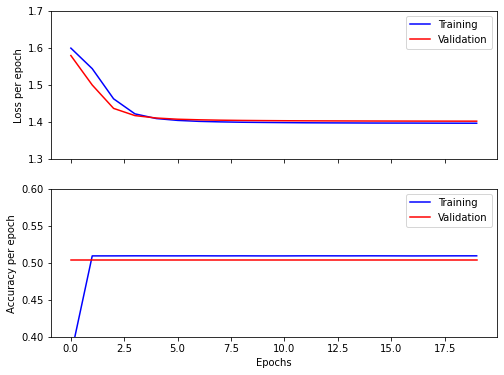

In [28]:
#this block is taken from exercise 8.1
eps = np.arange(N_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.set_ylim([1.3, 1.7])
ax1.plot(epoch_loss_train,'b')
ax1.plot(epoch_loss_valid,'r')
ax1.set_ylabel("Loss per epoch")
ax1.legend(["Training","Validation"])

ax2.set_ylim([0.4, 0.6])
ax2.plot(epoch_accuracy_train,'b')
ax2.plot(epoch_accuracy_valid,'r')
ax2.set_ylabel("Accuracy per epoch")
ax2.set_xlabel("Epochs")
ax2.legend(["Training","Validation"])

plt.show()

In [29]:
'''
Although both training and validation accuracy remain flat after epoch 1, there is a steady downward trend in terms of both training and validation accuracy,
indicating that the model is not fully trained. Larger epoch number should be implemented for further work.

While increasing learning rate is a potential option, this has been tried but validation loss remained constant, which is why this method is not presented.
'''

'\nAlthough both training and validation accuracy remain flat after epoch 1, there is a steady downward trend in terms of both training and validation accuracy,\nindicating that the model is not fully trained. Larger epoch number should be implemented for further work.\n\nWhile increasing learning rate is a potential option, this has been tried but validation loss remained constant, which is why this method is not presented.\n'

Accuracy:  0.516083557606049 
 F1-score:  0.13616229923922232 
 Precision:  0.10321671152120979 
 Recall:  0.2 



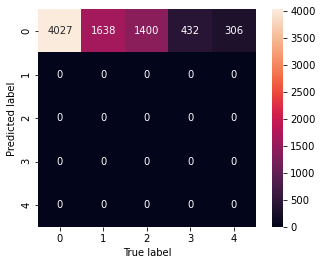

None
Accuracy:  0.2791164658634538 
 F1-score:  0.1454735740450026 
 Precision:  0.0930388219544846 
 Recall:  0.3333333333333333 



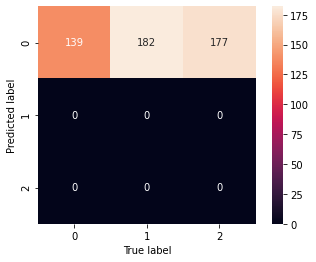

None


(None, None)

In [30]:
#this block only works when the last epoch is the best epoch (in this case it is)
test_fun_lstm(model,test_rmtr_iterator) #test the selected model on rmtr testing set
test_fun_lstm(model,test_s140_iterator) #test the selected model on s140 testing set

In [31]:
#predict function
def predict_post(text,model):
    label_dic={0:'Negative',1:'Somewhat Negative',2:'Neutral',3:'Somewhat Positive',4:'Positive'}
    tokenised=[i.lower() for i in word_tokenize(text) if i not in stopwords.words('english')]
    sentence=[' '.join(i for i in tokenised if len(i)>1)]

    if model.endswith('.pkl'): #do when NB models are called
        with open(model,'rb') as file:
            nb_model=pickle.load(file)
        predicted_class=nb_model.predict(sentence)[0] #extract the predicted label from np.array

    elif model.endswith('.pth'): #do when NNs are called
        vocabulary=torch.load('vocab.pth')
        #the next 3 lines are from workshop 8.4
        indexed = [vocabulary.stoi[token] for token in tokenised]
        tensor = torch.LongTensor(indexed).to(device)
        tensor = tensor.unsqueeze(1).T
    
        if model=='LSTM.pth': #do when LSTM model is called
            #the next 2 lines are from workshop 8.4
            length = [len(indexed)]
            length_tensor = torch.LongTensor(length)
            lstm_model=torch.load('LSTM.pth')
            lstm_model.eval()
            prediction = lstm_model(tensor, length_tensor)
            predicted_class=prediction.argmax(1, keepdim = True).item() #extract predicted label from tensor
        
        elif model=='CNN.pth': #do when CNN is called
            cnn_model=torch.load('CNN.pth')
            cnn_model.eval()
            prediction=cnn_model(tensor)
            predicted_class=prediction.argmax(1, keepdim = True).item() #extract predicted label from tensor

    output=label_dic[predicted_class]    
    return output

In [32]:
test_text_pos='the plot was interesting'
test_text_neg='worst, movie ever. my fault to have watched this'
noise='nhnf ihijn ihujrgl'

print('CNN: ',predict_post(test_text_neg,'CNN.pth'),predict_post(test_text_pos,'CNN.pth'),predict_post(noise,'CNN.pth'))
print('LSTM: ',predict_post(test_text_neg,'LSTM.pth'),predict_post(test_text_pos,'LSTM.pth'),predict_post(noise,'LSTM.pth'))
print('NB on RMTR: ',predict_post(test_text_neg,'NB_rtmr.pkl'),predict_post(test_text_pos,'NB_rtmr.pkl'),predict_post(noise,'NB_rtmr.pkl'))

CNN:  Negative Negative Negative
LSTM:  Negative Negative Negative
NB on RMTR:  Neutral Neutral Neutral
